<a href="https://colab.research.google.com/github/leniwiecc/SQLAlchemy-klocek/blob/main/Klocek_SQLAlchemy_cz3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cześć, jak tam? Magiczne kociołki zainstalowane? Jakieś pierwsze tabelki już zrobione? Dziś będzie praktyczny przykład:  sklep internetowy. Zrobimy bazę danych (dość uproszczoną). Stworzymy 3 tabele: użytkowników, zamówień i produktów a do tego relacje 1 do wielu i wiele do wielu: jeden użytkownik może mieć  wiele zamówień ale każde zamówienie ma tylko 1 właściciela (1 do wielu). Każde zamówienie może zawierać wiele produktów i każdy produkt może być w wielu zamówieniach (relacja wiele do wielu). To co, zaczynamy. Zaczniemy od wykreownania odpowienich tabel:

In [ ]:
products_orders= db.Table('products_orders',
    db.Column('order_id', db.Integer,   db.ForeignKey('ORDERS.id')),
    db.Column('product_id', db.Integer, db.ForeignKey('PRODUCTS.id'))                        
    )

class USERS(db.Model):
    id = db.Column(db.Integer, primary_key=True)
    username= db.Column(db.String(255), nullable=False, unique=True)
    password= db.Column(db.String(255), nullable=False, unique=False)
    mail=db.Column(db.String(255), nullable=False, unique=True)
    orders =  db.relationship('ORDERS', backref='wlasciciel', lazy='select') 
    ## celowo wpisałme to po polsku żeby później zrozumiec jak się do tego odwołać.
    
class PRODUCTS(db.Model):
    id = db.Column(db.Integer, primary_key=True)
    name= db.Column(db.String(255), nullable=False, unique=True)
    price= db.Column(db.Float(), nullable=False)
     
    
class ORDERS(db.Model):
    id=db.Column(db.Integer, primary_key=True)
    owner= db.Column(db.Integer,  db.ForeignKey('USERS.id'), nullable = False)
    products = db.relationship('PRODUCTS', secondary = 'produkts_orders', backref=db.backref('produkty'), lazy='select')
    ## celowo jest polska nazwa żeby później zobaczyć co jest product'em a co produktem. 

db.create_all()

Tworzenie tabel omawialiśmy wcześniej więc nie będę się powtarzał. Przyjrzyjmy się tabelom USERS i ORDERS. W tabeli ORDERS mamy kolumnę owner (właściciel czyli użytkownik, który stworzył to zamówienie): deklarujemy że będzie to kolumna int, db.ForeignKey('USERS.id') -> powoduje że z tabeli USERS będziemy brać pole id (które będziemy wstawiać do kolumny owner w tabeli orders). FOREIGN KEY znany jako klucz obcy to pewnego rodzaju odnośnik łączący tabelę w którym występuje klucz obcy z inną tabelą. Klucz obcy zapobiega wszelkim operacjom, które mogłyby zerwać taką więź międzu tabelami. Również klucz obcy nie może być wartością dowolną. Musi wskazyswać na konkretny wiersz w drugiej tabeli. Taka jest oficjalna definicja. Czy to jest zrozumiałe?
Natomiast w tabeli USERS mamy taką nowość: deklarujemy relacje: orders =  db.relationship('ORDERS', backref='wlasciciel', lazy='select'). ORDERS to tabela z którą się łączymy, parametr backref - to nazwa po jakiej się będziemy odwoływać w zapytaniach (o tym później), parametr lazy określa sposób ładowania danych przy łączeniu tabel. Jeżeli chcecie zagłębić temat to odsyłam do dokumentacji: https://docs.sqlalchemy.org/en/14/orm/loading_relationships.html

Dodajmy paru użytkowników i kilka zamówień żeby sprawdzić jak to działa:

In [ ]:
user1 = USERS(username='Tomek', password='pass', mail='tomek@hm.com')
user2 = USERS(username='Kasia', password='kasia1234', mail='kasia@buziaczek.pl')
db.session.add([user1, user2))
db.session.commit()

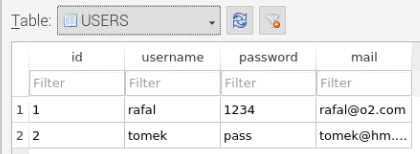

Zamówienie możemy dodać na dwa sposoby:

In [ ]:
user = USERS.query.get(1) ## pobieramy danego użytkownika, możemy to zrobić inaczej:  metodą filer_by
zam1 = ORDERS(owner=user.id)

## a inny spobób to po prostu wpisanie konkretnego numeru id użytkownika:
zam2 = ORDERS(owner=1)
zam3 = ORDERS(owner=2)

db.session.add([zam1, zam2, zam3])
db.session.commit()


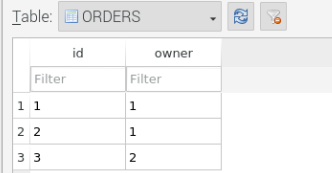

To teraz zobaczmy co nam się udało wstawić do bazy:

In [ ]:
users=USERS.query.all()
for user in users:
   print('Użytkownik: {}, a jego zamówienia to:'.format(user.username))
   orders = ORDERS.query.filter(ORDERS.owner == user.id).all()
   for order in orders:
        print('\t- Zamówienie o nr: {}, id_użytkownika: {}, imię użytkownika: {}'.format(order.id, order.owner, order.wlasciciel.username))

Powyższy kod powinien zwrócić coś w stylu:

```
Użytkownik: rafal, a jego zamówienia to:
	- Zamówienie o nr: 1, id_użytkownika: 1, imię użytkownika: rafal
	- Zamówienie o nr: 2, id_użytkownika: 1, imię użytkownika: rafal
Użytkownik: tomek, a jego zamówienia to:
	- Zamówienie o nr: 3, id_użytkownika: 2, imię użytkownika: tomek
```
zmienna owner.order zwraca nam id użytkownika natomiast wlasciciel (o którym wczesniej wspominałem) odnosi się do tabeli USERS i po kropce możemy odnosić się do każdej wartości USERS'a (czyli u nas może to być: username, password, mail).
Teraz dodajmy kilka produktów do tabeli PRODUCTS:


In [ ]:
o = PRODUCTS(name='ogórek', price=3.99)
z = PRODUCTS(name='ziemniak', price=0.99)
c = PRODUCTS(name='CD', price=12.55)

db.session.add([o, z, c])
db.session.commit()

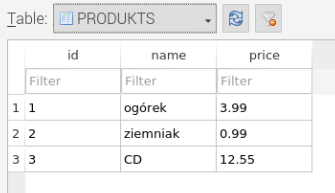

Teraz pora na omówienie relacji wiele do wielu. Jak już się domyślacie nie możemy tego zrobić tak samo jak powyżej. Musimy zrobić dodatkową tabelę w której będziemy trzymać id_zamówienia oraz id_produktu. Wybierając z tej tableli wszystkie wpisy o danym id_zamówienia otrzymamy listę produktów z tego zamówienia; a filtrując dane przez dane id_produktu zobaczymy listę zamówień, które zawierają dany produkt. Taką tabelę deklarujemy trochę inaczej: 

In [ ]:
products_orders= db.Table('products_orders', ## nazwa tabeli
    db.Column('order_id', db.Integer,   db.ForeignKey('ORDERS.id')), ## nazwa kolumny, typ danych i odwołanie do 
    db.Column('product_id', db.Integer, db.ForeignKey('PRODUCTS.id'))                        
    )

# musimy jeszcze dodać relację w Klasie ORDERS:
products = db.relationship('PRODUCTS', secondary = 'products_orders', backref=db.backref('produkty'), lazy='select')



w nawiasie w pierwszym miejscu mamy odniesienie do drugiej tabeli, parametr secondary określa tabelę do której jest to odwołanie.
Dodajmy jakieś produkty do zamówienia:

In [ ]:
 
c = PRODUCTS.query.get(1)   #pobieramy konkretny produkt
zam = ORDERS.query.get(1)   #pobieramy konkrente zamówienie

zam.products.append(c)  
# po nazwie zamówienia podajemy nazwę relacji. Ta klasa ma metodę append
# tak samo jak w liście. Czyli do danego zamówienia dołączamy produkt.

db.session.commit()

To teraz zobaczmy co mamy w koszyku:

In [ ]:
zam = ORDERS.query.get(1)
print('Lista produktów z zamówienia o id: {}'.format(zam.id))
for produkt in zam.products:
     print(' - {}, {}'.format(produkt.name, produkt.price))


Powyższy kod powinien zwrócić coś takiego:

```
Lista produktów z zamówienia o id: 1
 - ziemniak, 0.99
 - ogórek, 3.99
```



I to by było wszystko co chciałem Wam przekazać. Bierzcie i korzystajcie z tego bez ograniczeń :) Jak coś to pisać śmiało, RafalK.